### INSTALLING SQLALCHEMY

In [1]:
%pip install sqlalchemy



### INSTALLING PYODBC

In [2]:
%pip install pyodbc


### INSTALLING MYSQL CONNECTOR PYTHON 

In [3]:
%pip install mysql-connector-python


Note: you may need to restart the kernel to use updated packages.


### This Python script establishes a connection to a MySQL database, loads data from a CSV file into a Pandas DataFrame, and then writes that DataFrame to a MySQL table.

In [4]:
import sqlalchemy
import pandas as pd

# Define your MySQL connection string
username = 'sumedha1024'
password = '1024'
host = '172.20.0.3'
port = '3306'
database_name = 'projectdb'

conn_str = f"mysql+mysqlconnector://{username}:{password}@{host}:{port}/{database_name}"

# Create SQLAlchemy engine
engine = sqlalchemy.create_engine(conn_str)

# Load CSV into pandas DataFrame
csv_file_path = 'supermarket_sales.csv'
df = pd.read_csv(csv_file_path)

# Replace 'table_name' with the name you want for your SQL table
table_name = 'marketsales'

# Write DataFrame to MySQL table
df.to_sql(table_name, engine, if_exists='replace', index=False)

print("CSV data successfully loaded into MySQL.")


CSV data successfully loaded into MySQL.


### This code defines a SQLAlchemy declarative base class and a class MarketSales that maps to the 'marketsales' table in a MySQL database. Each column in the table is represented by an attribute of the class, with its respective data type and optional parameters specified using SQLAlchemy's Column function.

In [5]:
from sqlalchemy import Column, Integer, String, Float, Date, Time
from sqlalchemy.ext.declarative import declarative_base

Base = declarative_base()

class MarketSales(Base):
    __tablename__ = 'marketsales'

    Invoice_ID = Column('Invoice ID',String, primary_key=True)
    Branch = Column(String)
    City = Column(String)
    Customer_type = Column(String, name='Customer type')
    Gender = Column(String)
    Product_line = Column(String, name='Product line')
    Unit_price = Column(Float, name='Unit price')
    Quantity = Column(Integer)
    Tax_5 = Column(Float, name='Tax 5%')
    Total = Column(Float)
    Date = Column(String)  
    Time = Column(String)
    Payment = Column(String)
    cogs = Column(Float)
    gross_margin_percentage = Column(Float, name='gross margin percentage')
    gross_income = Column(Float, name='gross income')
    Rating = Column(Float)


/var/folders/_2/5lvqnbls34v4qlycmd5kdrc40000gn/T/ipykernel_84037/4129649081.py:4: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


SQLAlchemy retrieves the product line and calculates the sum of total sales for each product line from the marketsales table

In [6]:
from sqlalchemy.orm import sessionmaker
from sqlalchemy import func

# Create a session
Session = sessionmaker(bind=engine)
session = Session()

# Calculate total sales per product line
total_sales_per_product_line = session.query(MarketSales.Product_line, func.sum(MarketSales.Total).label('total_sales')) \
                                      .group_by(MarketSales.Product_line) \
                                      .all()

# Print the results
for product_line, total_sales in total_sales_per_product_line:
    print(f"Product Line: {product_line}, Total Sales: {total_sales}")


Product Line: Health and beauty, Total Sales: 49193.739000000016
Product Line: Electronic accessories, Total Sales: 54337.531500000005
Product Line: Home and lifestyle, Total Sales: 53861.91300000001
Product Line: Sports and travel, Total Sales: 55122.826499999996
Product Line: Food and beverages, Total Sales: 56144.844000000005
Product Line: Fashion accessories, Total Sales: 54305.895


### Code fetches a record from the 'MarketSales' table based on the Invoice_ID, updates some fields, and commits the changes to the database session.

In [7]:
# Fetch the record to update
record_to_update = session.query(MarketSales).filter_by(Invoice_ID='750-67-8428').first()

if record_to_update:
    # Update the fields
    record_to_update.Branch = 'B'
    record_to_update.Quantity = 8
    record_to_update.Total = record_to_update.Unit_price * record_to_update.Quantity * (1 + record_to_update.Tax_5 / 100)

    # Commit the changes
    session.commit()
    print("Record updated.")
else:
    print("Record not found. Cannot update.")


Record updated.


### Code creates a new record of MarketSales class with the specified attributes, adds it to the session, commits the changes to the database, and then queries for the inserted record based on its Invoice_ID.

In [8]:
# Create a new record
new_record = MarketSales(
    Invoice_ID='123-45-6789',
    Branch='C',
    City='Yangon',
    Customer_type='Member',
    Gender='Male',
    Product_line='Sports and travel',
    Unit_price=99.99,
    Quantity=5,
    Tax_5=4.9995,
    Total=574.99475,
    Date='4/15/2019',
    Time='14:30',
    Payment='Credit card',
    cogs=499.995,
    gross_margin_percentage=5.0,
    gross_income=74.99975,
    Rating=8.2
)

# Add the new record to the session
session.add(new_record)

# Commit the changes to the database
session.commit()


# Query for the inserted record
inserted_record = session.query(MarketSales).filter_by(Invoice_ID='123-45-6789').first()

if inserted_record:
    print("Record inserted successfully:")
    print("Invoice ID:", inserted_record.Invoice_ID)
    print("Branch:", inserted_record.Branch)
    # Print other fields similarly
else:
    print("Record not found. Insertion failed.")




Record inserted successfully:
Invoice ID: 123-45-6789
Branch: C


### Code queries for a specific record in the 'MarketSales' table based on its Invoice_ID, deletes it if found, commits the changes to the database, and then queries again to ensure the record was successfully deleted.

In [9]:
# Query for the record to delete
record_to_delete = session.query(MarketSales).filter_by(Invoice_ID='123-45-6789').first()

if record_to_delete:
    # Delete the record
    session.delete(record_to_delete)
    
    # Commit the changes
    session.commit()
    
    print("Record found.")
else:
    print("Record not found. Cannot delete.")


deleted_record = session.query(MarketSales).filter_by(Invoice_ID='123-45-6789').first()

if not deleted_record:
    print("Record deleted successfully.")
else:
    print("Record still exists. Deletion failed.")


Record found.
Record deleted successfully.


### Code queries for records in the 'MarketSales' table where the 'Unit_price' is greater than 50, retrieves all the matching records, and then iterates through each record, printing the 'Invoice ID' and 'Branch' attributes.

In [10]:
records = session.query(MarketSales).filter(MarketSales.Unit_price > 50).all()

# Print or show the results
for record in records:
    print("Invoice ID:", record.Invoice_ID)
    print("Branch:", record.Branch)

Invoice ID: 750-67-8428
Branch: B
Invoice ID: 123-19-1176
Branch: A
Invoice ID: 373-73-7910
Branch: A
Invoice ID: 699-14-3026
Branch: C
Invoice ID: 355-53-5943
Branch: A
Invoice ID: 315-22-5665
Branch: C
Invoice ID: 692-92-5582
Branch: B
Invoice ID: 829-34-3910
Branch: A
Invoice ID: 299-46-1805
Branch: B
Invoice ID: 656-95-9349
Branch: A
Invoice ID: 765-26-6951
Branch: A
Invoice ID: 329-62-1586
Branch: A
Invoice ID: 300-71-4605
Branch: C
Invoice ID: 371-85-5789
Branch: B
Invoice ID: 549-59-1358
Branch: A
Invoice ID: 227-03-5010
Branch: A
Invoice ID: 189-17-4241
Branch: A
Invoice ID: 145-94-9061
Branch: B
Invoice ID: 871-79-8483
Branch: B
Invoice ID: 149-71-6266
Branch: B
Invoice ID: 640-49-2076
Branch: B
Invoice ID: 595-11-5460
Branch: A
Invoice ID: 183-56-6882
Branch: C
Invoice ID: 232-16-2483
Branch: C
Invoice ID: 129-29-8530
Branch: A
Invoice ID: 272-65-1806
Branch: A
Invoice ID: 333-73-7901
Branch: C
Invoice ID: 280-35-5823
Branch: B
Invoice ID: 554-53-8700
Branch: C
Invoice ID: 35

### Code queries for a limited number of records (in this case, 10) from the 'MarketSales' table, retrieves all the matching records, and then iterates through each record, printing the 'Invoice ID', 'City', and 'Product Line' attributes.

In [11]:

limited_records = session.query(MarketSales).limit(10).all()

# Print the limited records
for record in limited_records:
    print("Invoice ID:", record.Invoice_ID)
    print("City:", record.City)
    print("Product Line:", record.Product_line)
    print()  # Print an empty line for readability


Invoice ID: 750-67-8428
City: Yangon
Product Line: Health and beauty

Invoice ID: 226-31-3081
City: Naypyitaw
Product Line: Electronic accessories

Invoice ID: 631-41-3108
City: Yangon
Product Line: Home and lifestyle

Invoice ID: 123-19-1176
City: Yangon
Product Line: Health and beauty

Invoice ID: 373-73-7910
City: Yangon
Product Line: Sports and travel

Invoice ID: 699-14-3026
City: Naypyitaw
Product Line: Electronic accessories

Invoice ID: 355-53-5943
City: Yangon
Product Line: Electronic accessories

Invoice ID: 315-22-5665
City: Naypyitaw
Product Line: Home and lifestyle

Invoice ID: 665-32-9167
City: Yangon
Product Line: Health and beauty

Invoice ID: 692-92-5582
City: Mandalay
Product Line: Food and beverages



### Code uses Matplotlib to create a histogram of unit prices extracted from the 'MarketSales' table. It queries all unit prices, creates a histogram with 20 bins, labels the axes, titles the plot, adds grid lines for better visualization

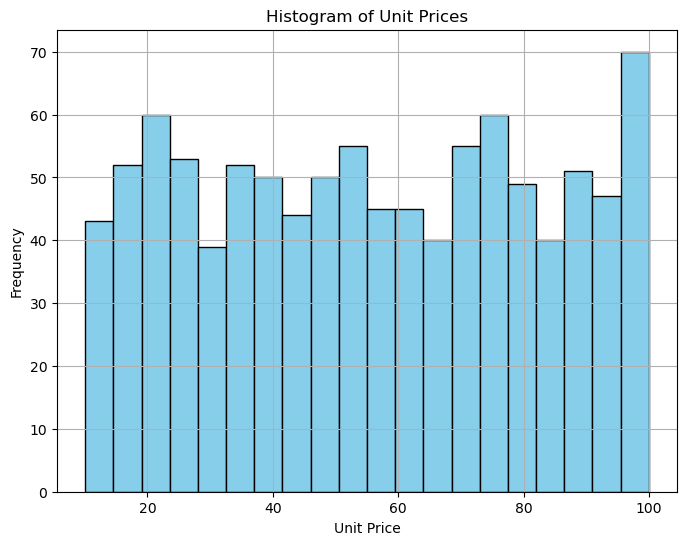

In [12]:
import matplotlib.pyplot as plt

# Query to get unit prices
unit_prices = [record.Unit_price for record in session.query(MarketSales).all()]

# Create histogram
plt.figure(figsize=(8, 6))
plt.hist(unit_prices, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Unit Price')
plt.ylabel('Frequency')
plt.title('Histogram of Unit Prices')
plt.grid(True)
plt.show()


### Code uses Matplotlib to create a scatter plot of quantity against total sales extracted from the 'MarketSales' table. It queries all quantities and total sales, creates a scatter plot with green dots and transparency (alpha=0.5) for better visualization

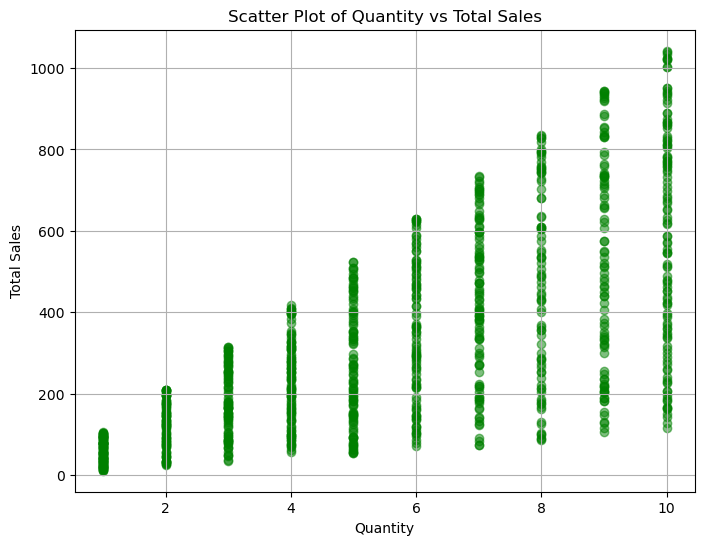

In [13]:
import matplotlib.pyplot as plt

# Query to get quantity and total sales
quantities = [record.Quantity for record in session.query(MarketSales).all()]
total_sales = [record.Total for record in session.query(MarketSales).all()]

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(quantities, total_sales, color='green', alpha=0.5)
plt.xlabel('Quantity')
plt.ylabel('Total Sales')
plt.title('Scatter Plot of Quantity vs Total Sales')
plt.grid(True)
plt.show()


### Code uses Matplotlib to create a pie chart representing the distribution of payment methods extracted from the 'MarketSales' table. It queries the payment methods along with their frequencies, extracts the labels and sizes, creates a pie chart with percentages 

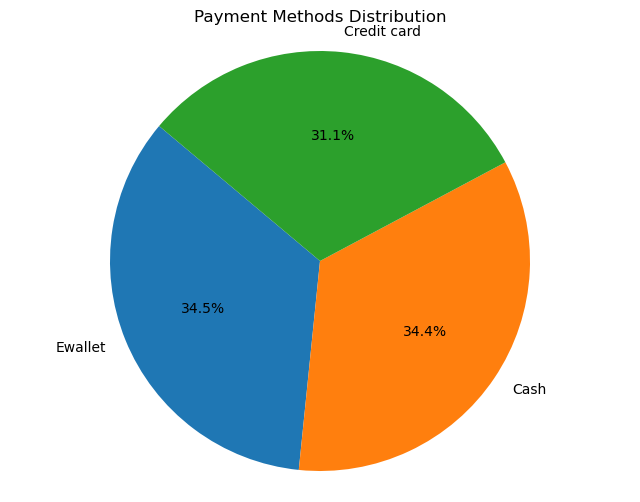

In [14]:
import matplotlib.pyplot as plt

# Query to get payment methods and their frequencies
payment_methods = session.query(MarketSales.Payment, func.count(MarketSales.Payment)) \
                         .group_by(MarketSales.Payment) \
                         .all()

# Extract payment methods and frequencies
labels = [method[0] for method in payment_methods]
sizes = [method[1] for method in payment_methods]

# Create pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Payment Methods Distribution')
plt.show()


### Code executes a SQL query to retrieve data from the 'marketsales' table where both the 'Date' and 'Total' columns are not null. It then reads the data into a Pandas DataFrame, converts the 'Date' column to datetime format, groups the data by date, and sums the total sales for each day. 

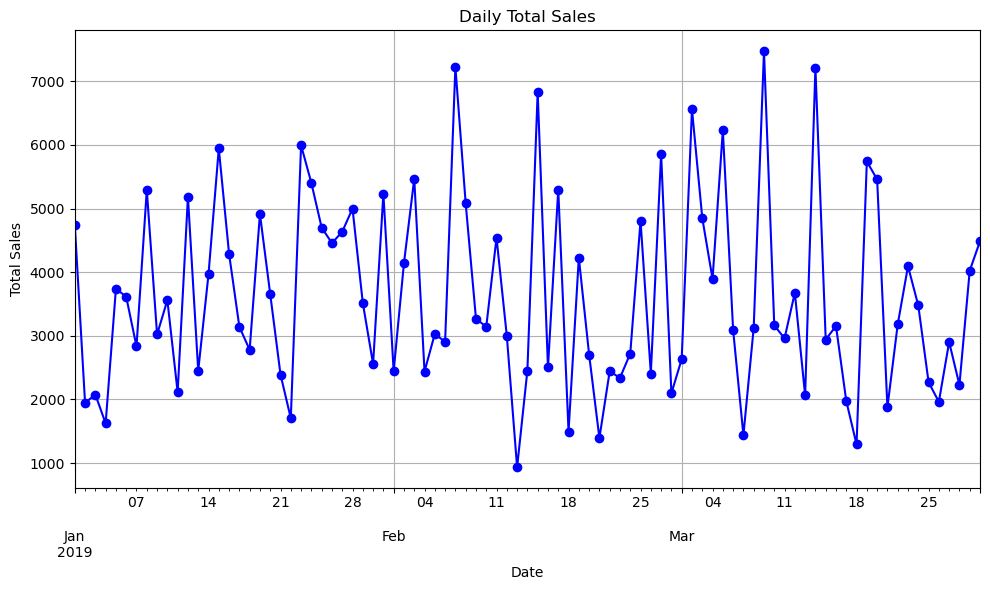

In [15]:
# Query the necessary data from the 'marketsales' table
query = "SELECT Date, Total FROM marketsales WHERE Date IS NOT NULL AND Total IS NOT NULL"
data = pd.read_sql(query, engine)

data['Date'] = pd.to_datetime(data['Date'])

# Group by date and sum the total sales
daily_sales = data.groupby('Date')['Total'].sum()

# Plot the daily total sales
plt.figure(figsize=(10, 6))
daily_sales.plot(marker='o', linestyle='-', color='blue')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Daily Total Sales')
plt.grid(True)
plt.tight_layout()
plt.show()


### Code retrieves unique product lines from the 'MarketSales' table, calculates the total quantity sold for each product line, and then creates a bar plot showing the quantity sold by product line using Matplotlib.

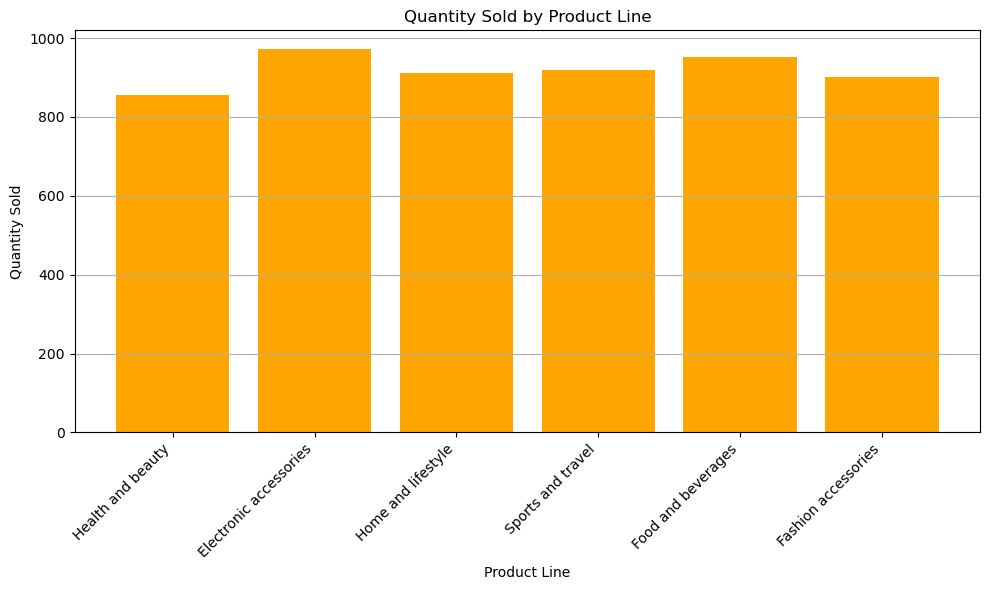

In [16]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Query to get product lines and quantities
product_lines = session.query(MarketSales.Product_line).distinct().all()
product_lines = [line[0] for line in product_lines]

quantities_by_product_line = defaultdict(int)
for line in product_lines:
    quantities_by_product_line[line] = sum([record.Quantity for record in session.query(MarketSales).filter_by(Product_line=line).all()])

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(quantities_by_product_line.keys(), quantities_by_product_line.values(), color='orange')
plt.xlabel('Product Line')
plt.ylabel('Quantity Sold')
plt.title('Quantity Sold by Product Line')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### Code fetches data from the 'marketsales' table, preprocesses it, builds a pipeline with a RandomForestRegressor model, trains the model, makes predictions on the test set, evaluates the model using various regression metrics, and prints the evaluation results.

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Fetch data from the database
query = "SELECT * FROM marketsales"
data = pd.read_sql(query, engine)

# Data preprocessing
numerical_cols = ['Unit price', 'Quantity', 'Tax 5%', 'Total', 'cogs', 'gross margin percentage', 'Rating']
categorical_cols = ['Branch', 'City', 'Customer type', 'Gender', 'Product line', 'Payment']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define features and target variable
X = data.drop(columns=['Invoice ID', 'gross income'])  # Remove irrelevant columns
y = data['gross income']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

# Train the model
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)  # RMSE
r2 = r2_score(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

classification_metrics = {
    'Mean Squared Error': [mse],
    'Root Mean Squared Error': [rmse],
    'R-squared Score': [r2],
    'Mean Absolute Error': [mae]
}

# Create a DataFrame from the metrics dictionary
metrics_df = pd.DataFrame(classification_metrics)

# Print classification report-style output
print(metrics_df.to_string(index=False))

 Mean Squared Error  Root Mean Squared Error  R-squared Score  Mean Absolute Error
           0.005008                  0.07077         0.999966             0.037767


/Users/sumedhavadlamani/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Code creates a scatter plot to visualize the relationship between actual and predicted gross income. It plots the actual gross income (y_test) against the predicted gross income (predictions) from the regression model.

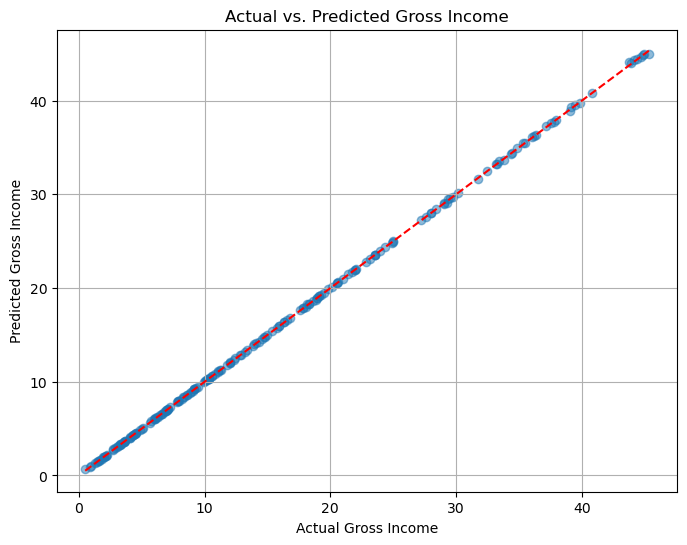

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')  # Perfect prediction line
plt.title('Actual vs. Predicted Gross Income')
plt.xlabel('Actual Gross Income')
plt.ylabel('Predicted Gross Income')
plt.grid(True)
plt.show()

### Code uses Plotly Express to create an interactive bar plot showing the average rating by product line and city. It visualizes the 'Rating' column against the 'Product line' column, with bars colored by the 'City' column. The barmode='group' parameter arranges bars for different cities side by side for each product line.

In [26]:
import plotly.express as px

# Example using Plotly Express to create an interactive bar plot
fig = px.bar(data, x='Product line', y='Rating', color='City', barmode='group',
             height=400, title='Average Rating by Product Line and City')
fig.show()


In [27]:
data.columns

Index(['Invoice ID', 'Branch', 'City', 'Customer type', 'Gender',
       'Product line', 'Unit price', 'Quantity', 'Tax 5%', 'Total', 'Date',
       'Time', 'Payment', 'cogs', 'gross margin percentage', 'gross income',
       'Rating'],
      dtype='object')

### Code saves the trained RandomForestRegressor model to a file named 'randomforest.pkl' using the pickle module. The model can be loaded from this file later for reuse.

In [28]:
import pickle

# Define the file path where you want to save the model
model_filename = 'randomforest.pkl'

# Save the model to the file path using pickle
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)

print("Model saved as:", model_filename)


Model saved as: randomforest.pkl
